Epoch 1/100


d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1332 - val_loss: 0.0170
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0108
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - val_loss: 0.0058
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0067
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 - val_loss: 0.0059
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0058
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0107
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0057
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0062
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - val_loss: 0.0056
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0055
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_lo

d:\Python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_11560\84608745.py:82: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_features.fillna(method='ffill', inplace=True)


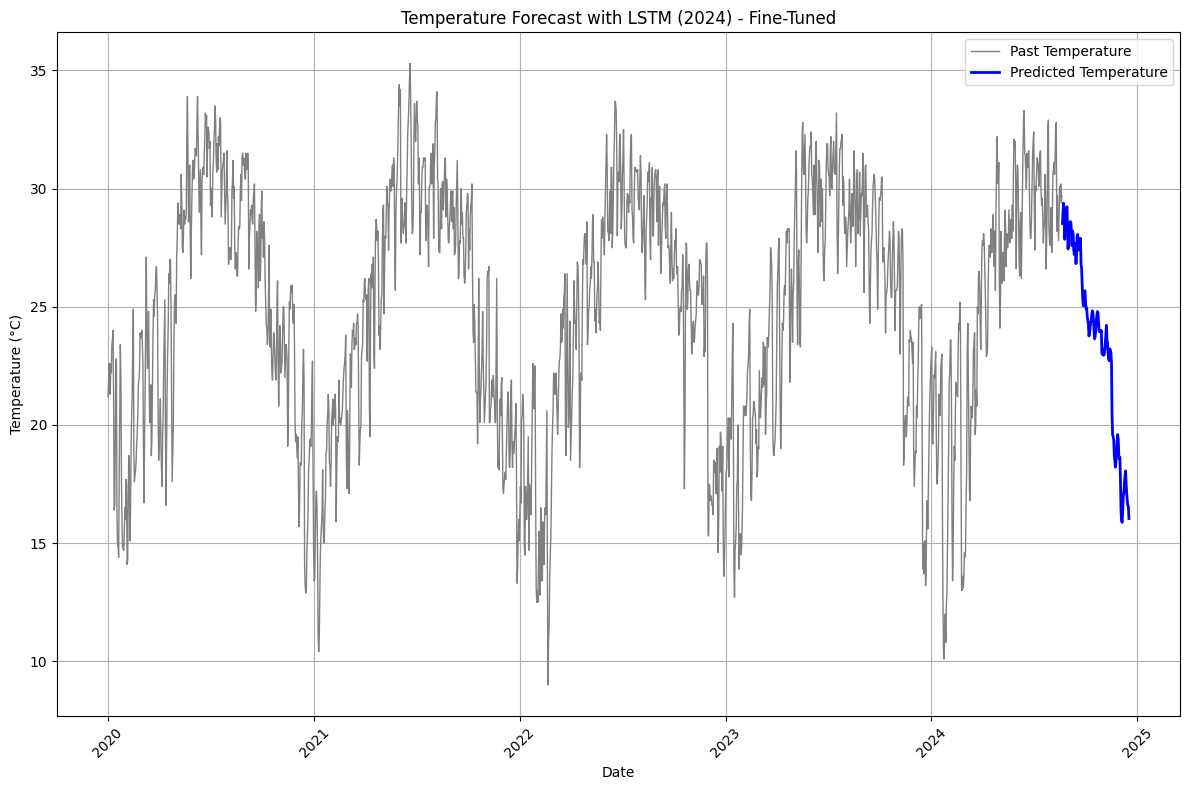

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# Step 1: Load the dataset
file_path = '../dataset/Data.csv'
data = pd.read_csv(file_path)
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Step 2: Extract features and labels
X = data[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity', 'day_of_year']]
y = data['temp']

# Step 3: Normalize the features and labels
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Step 4: Create sequences for LSTM
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(labels[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 14  # Try a longer sequence length
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Step 5: Train-test split
split_index = int(len(X_seq) * 0.8)
X_train = X_seq[:split_index]
X_test = X_seq[split_index:]
y_train = y_seq[:split_index]
y_test = y_seq[split_index:]

# Step 6: Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, X_seq.shape[2])))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Step 7: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])

# Step 8: Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Step 9: Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Step 10: Generate future dates
future_dates = pd.date_range(start='2024-08-21', end='2024-12-31')
future_day_of_year = future_dates.dayofyear

# Step 11: Create future features using historical averages
historical_averages = data.groupby('day_of_year')[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']].mean()

future_features = pd.DataFrame({'day_of_year': future_day_of_year})
for col in ['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']:
    future_features[col] = future_features['day_of_year'].map(historical_averages[col])
future_features = future_features[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity', 'day_of_year']]
future_features.fillna(method='ffill', inplace=True)
future_features_scaled = scaler_X.transform(future_features)

# Step 12: Create sequences for future prediction
future_sequences, _ = create_sequences(future_features_scaled, np.zeros(len(future_features_scaled)), seq_length)

# Adjust future_dates if necessary
num_future_sequences = len(future_sequences)
if num_future_sequences < len(future_dates) - seq_length:
    future_dates = future_dates[-num_future_sequences:]

# Step 13: Predict future temperatures
future_predictions_scaled = model.predict(future_sequences)
future_predictions = scaler_y.inverse_transform(future_predictions_scaled)

# Step 14: Save predictions
future_data = pd.DataFrame({
    'Date': future_dates[:len(future_predictions)],
    'Predicted Temperature': future_predictions.flatten()
})
future_data.to_csv('future_weather_predictions_lstm_finetuning.csv', index=False)

# Step 15: Plot the forecasted temperature and historical data
plt.figure(figsize=(12, 8))
plt.plot(data['datetime'], data['temp'], color='grey', label='Past Temperature', linewidth=1)
plt.plot(future_data['Date'], future_data['Predicted Temperature'], color='blue', label='Predicted Temperature', linewidth=2)
plt.title("Temperature Forecast with LSTM (2024) - Fine-Tuned")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
